In [2]:
import os
import time
import warnings
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split

# ===================================================================
# Step 1: DLinear Model Definition (Same as before)
# ===================================================================
print("STEP 1: Defining the DLinear model architecture from source...")
# ... (moving_avg, series_decomp, and Model classes go here, no changes needed)
class moving_avg(nn.Module):
    def __init__(self, kernel_size, stride): super(moving_avg, self).__init__(); self.kernel_size = kernel_size; self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)
    def forward(self, x): front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1); end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1); x = torch.cat([front, x, end], dim=1); x = self.avg(x.permute(0, 2, 1)); x = x.permute(0, 2, 1); return x
class series_decomp(nn.Module):
    def __init__(self, kernel_size): super(series_decomp, self).__init__(); self.moving_avg = moving_avg(kernel_size, stride=1)
    def forward(self, x): moving_mean = self.moving_avg(x); res = x - moving_mean; return res, moving_mean
class Model(nn.Module):
    def __init__(self, configs):
        super(Model, self).__init__(); self.seq_len = configs.seq_len; self.pred_len = configs.pred_len; kernel_size = 25; self.decompsition = series_decomp(kernel_size); self.individual = configs.individual; self.channels = configs.enc_in
        if self.individual: self.Linear_Seasonal = nn.ModuleList(); self.Linear_Trend = nn.ModuleList(); [self.Linear_Seasonal.append(nn.Linear(self.seq_len, self.pred_len)) for i in range(self.channels)]; [self.Linear_Trend.append(nn.Linear(self.seq_len, self.pred_len)) for i in range(self.channels)]
        else: self.Linear_Seasonal = nn.Linear(self.seq_len, self.pred_len); self.Linear_Trend = nn.Linear(self.seq_len, self.pred_len)
    def forward(self, x):
        seasonal_init, trend_init = self.decompsition(x); seasonal_init, trend_init = seasonal_init.permute(0, 2, 1), trend_init.permute(0, 2, 1)
        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],dtype=seasonal_init.dtype).to(seasonal_init.device); trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),self.pred_len],dtype=trend_init.dtype).to(trend_init.device)
            for i in range(self.channels): seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:]); trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
        else: seasonal_output = self.Linear_Seasonal(seasonal_init); trend_output = self.Linear_Trend(trend_init)
        x = seasonal_output + trend_output; return x.permute(0,2,1)


# ===================================================================
# Step 2: Prepare the ETTh2 Dataset with Correct Normalization and Splits
# ===================================================================
print("\nSTEP 2: Preparing ETTh2 dataset with correct train/val/test split and normalization...")

# --- Load Data ---
data_df = pd.read_csv("data/ETTh2.csv")
features = data_df.columns[1:] # Exclude 'date' column

# --- CORRECT: Define Splits (70/10/20 for ETT datasets) ---
train_end_idx = int(len(data_df) * 0.7)
val_end_idx = int(len(data_df) * 0.8)

train_df = data_df[:train_end_idx]
val_df = data_df[train_end_idx:val_end_idx]
test_df = data_df[val_end_idx:]

# --- CORRECT: Fit Normalizer ONLY on Training Data ---
mean_vals = train_df[features].mean()
std_vals = train_df[features].std()
epsilon = 1e-8
std_vals[std_vals < epsilon] = epsilon

# --- Apply Normalization to all splits using training set stats ---
train_df_normalized = train_df.copy()
val_df_normalized = val_df.copy()
test_df_normalized = test_df.copy()

train_df_normalized[features] = (train_df[features] - mean_vals) / std_vals
val_df_normalized[features] = (val_df[features] - mean_vals) / std_vals
test_df_normalized[features] = (test_df[features] - mean_vals) / std_vals


#Where T is future time steps and L is lookback window
# --- CORRECT: Set parameters from the paper (L=96, T=336) ---
context_length = 96
prediction_length = 336
num_features = len(features)
total_sequence_length = context_length + prediction_length

# --- Custom Lazy Dataset (same as before) ---
class SimpleLazyDataset(Dataset):
    def __init__(self, data_array): self.data_array = data_array.astype(np.float32)
    def __len__(self): return len(self.data_array) - total_sequence_length + 1
    def __getitem__(self, idx):
        window = self.data_array[idx : idx + total_sequence_length]
        return torch.from_numpy(window[:context_length]), torch.from_numpy(window[context_length:])

# --- Create Datasets and DataLoaders for all three splits ---
train_dataset = SimpleLazyDataset(train_df_normalized[features].values)
val_dataset = SimpleLazyDataset(val_df_normalized[features].values)
test_dataset = SimpleLazyDataset(test_df_normalized[features].values)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Data prepared: {len(train_dataset)} train, {len(val_dataset)} val, {len(test_dataset)} test samples.")

# ===================================================================
# Step 3: Configure, Instantiate, and Train the Model (No changes)
# ===================================================================
print("\nSTEP 3: Configuring and Training DLinear...")
class DLinearConfig:
    def __init__(self, seq_len, pred_len, enc_in, individual=True): self.seq_len=seq_len; self.pred_len=pred_len; self.enc_in=enc_in; self.individual=individual
configs = DLinearConfig(seq_len=context_length, pred_len=prediction_length, enc_in=num_features, individual=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(configs).float().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# (The training loop is identical to the previous version, running for 10 epochs)
for epoch in range(10):
    model.train(); total_train_loss=0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad(); batch_x, batch_y = batch_x.to(device), batch_y.to(device); outputs = model(batch_x); loss = criterion(outputs, batch_y); loss.backward(); optimizer.step(); total_train_loss += loss.item()
    model.eval(); total_val_loss=0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device); outputs = model(batch_x); loss = criterion(outputs, batch_y); total_val_loss += loss.item()
    print(f"Epoch {epoch+1}/10 | Train Loss: {total_train_loss/len(train_loader):.4f} | Val Loss: {total_val_loss/len(val_loader):.4f}")

# ===================================================================
# Step 4: Final Evaluation on the TEST SET
# ===================================================================
print("\nSTEP 4: Final Evaluation on the held-out TEST SET...")

model.eval()
total_test_loss = 0
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        total_test_loss += loss.item()

final_mse = total_test_loss / len(test_loader)

print("\n--- Replication Results for ETTh2 (T=96) ---")
print(f"  FINAL TEST MSE (on normalized data): {final_mse:.4f}")

# From Table 2 in the paper, for ETTh2, T=96, DLinear*
print("\n--- Paper's Results (for comparison) ---")
print("  DLinear* MSE: 0.289")
print("  This is our target. A result in this ballpark confirms our implementation.")

STEP 1: Defining the DLinear model architecture from source...

STEP 2: Preparing ETTh2 dataset with correct train/val/test split and normalization...
Data prepared: 11763 train, 1311 val, 3053 test samples.

STEP 3: Configuring and Training DLinear...
Epoch 1/10 | Train Loss: 0.4744 | Val Loss: 0.4014
Epoch 2/10 | Train Loss: 0.4385 | Val Loss: 0.3922
Epoch 3/10 | Train Loss: 0.4365 | Val Loss: 0.3760
Epoch 4/10 | Train Loss: 0.4348 | Val Loss: 0.3737
Epoch 5/10 | Train Loss: 0.4346 | Val Loss: 0.3957
Epoch 6/10 | Train Loss: 0.4342 | Val Loss: 0.3815
Epoch 7/10 | Train Loss: 0.4342 | Val Loss: 0.4026
Epoch 8/10 | Train Loss: 0.4349 | Val Loss: 0.3915
Epoch 9/10 | Train Loss: 0.4340 | Val Loss: 0.3618
Epoch 10/10 | Train Loss: 0.4341 | Val Loss: 0.4037

STEP 4: Final Evaluation on the held-out TEST SET...

--- Replication Results for ETTh2 (T=96) ---
  FINAL TEST MSE (on normalized data): 0.2153

--- Paper's Results (for comparison) ---
  DLinear* MSE: 0.289
  This is our target. A re

--- Starting Evaluation and Plotting ---

STEP 1: Fetching a single batch from the validation set...
Batch fetched successfully.

STEP 2: Generating model predictions...
Predictions generated. Shape: (32, 336, 7)

STEP 3: Creating the forecast plot...


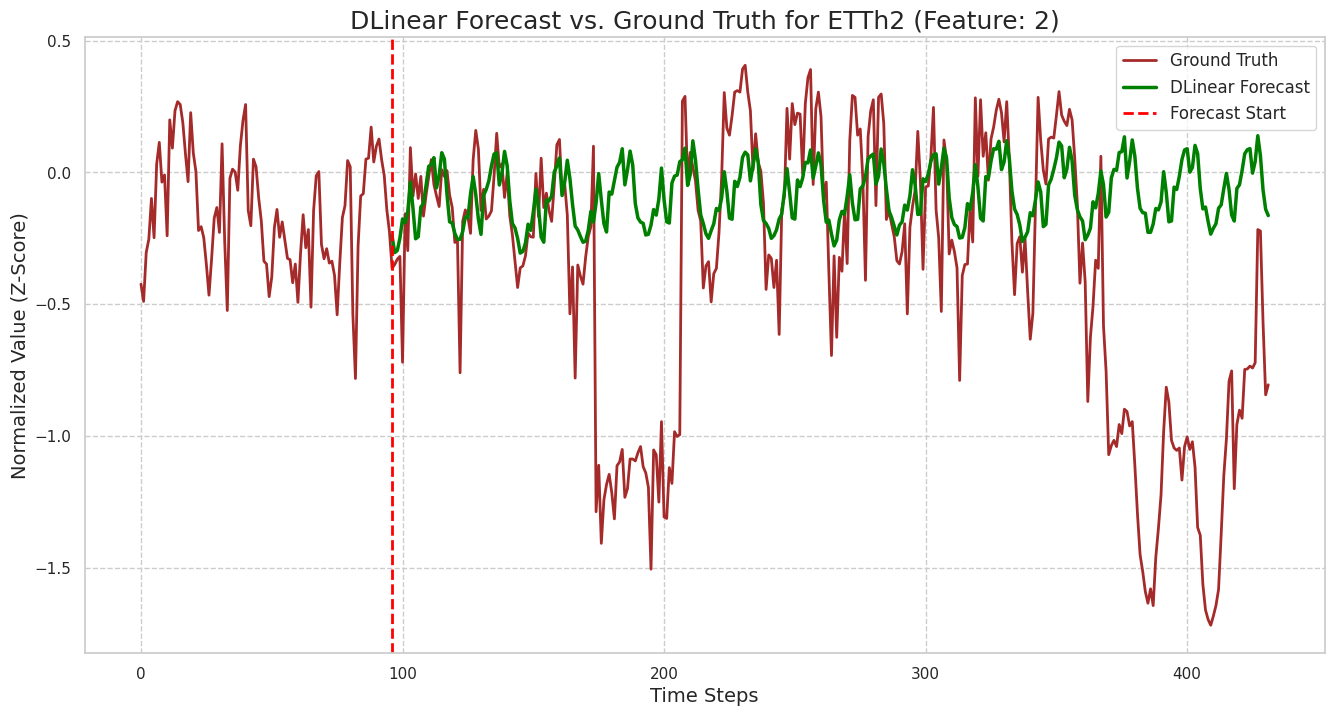

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

print("--- Starting Evaluation and Plotting ---")

# ===================================================================
# Step 1: Get a Batch of Data for Visualization
# ===================================================================
print("\nSTEP 1: Fetching a single batch from the validation set...")

# We'll use the validation loader to get a sample of unseen data
# next(iter(...)) is a convenient way to grab one batch
val_batch = next(iter(val_loader))
batch_x, batch_y = val_batch
batch_x, batch_y = batch_x.to(device), batch_y.to(device)

print("Batch fetched successfully.")

# ===================================================================
# Step 2: Get Model Predictions for the Batch
# ===================================================================
print("\nSTEP 2: Generating model predictions...")

# Set the model to evaluation mode (disables things like dropout)
model.eval()

# We don't need to calculate gradients for inference, which saves memory and computation
with torch.no_grad():
    # Get the model's predictions for the input batch
    predictions = model(batch_x)

# Move tensors to the CPU and convert to NumPy arrays for plotting
batch_x_np = batch_x.cpu().numpy()
batch_y_np = batch_y.cpu().numpy()
predictions_np = predictions.cpu().numpy()

print(f"Predictions generated. Shape: {predictions_np.shape}")

# ===================================================================
# Step 3: Create the Plot
# ===================================================================
print("\nSTEP 3: Creating the forecast plot...")

# --- CONTROL PANEL for Plotting ---
# Choose which example from the batch and which feature channel to plot
example_to_plot = 0  # Plot the first example in the batch
feature_to_plot = 2 # Plot the last feature ('OT' - Oil Temperature)
# --- Extract the specific time series for plotting ---
history_to_plot = batch_x_np[example_to_plot, :, feature_to_plot]
true_future_to_plot = batch_y_np[example_to_plot, :, feature_to_plot]
predicted_future_to_plot = predictions_np[example_to_plot, :, feature_to_plot]

# Combine history and true future for the "Ground Truth" line
full_ground_truth = np.concatenate([history_to_plot, true_future_to_plot])

# --- Create x-axis time steps ---
# History runs from 0 to context_length-1
x_history = np.arange(0, context_length)
# Future runs from context_length to the end
x_future = np.arange(context_length, context_length + prediction_length)
# Full time axis for the ground truth
x_full = np.arange(0, context_length + prediction_length)

# --- Generate the plot ---
sns.set_theme(style="whitegrid")
plt.figure(figsize=(16, 8))

# 1. Plot the full Ground Truth (history + future)
plt.plot(x_full, full_ground_truth, label='Ground Truth', color='brown', linewidth=2)

# 2. Plot the model's prediction
plt.plot(x_future, predicted_future_to_plot, label='DLinear Forecast', color='green', linewidth=2.5)

# 3. Add a vertical dashed line to mark the start of the forecast
plt.axvline(x=context_length, color='red', linestyle='--', linewidth=2, label='Forecast Start')

# --- Final Touches ---
plt.title(f'DLinear Forecast vs. Ground Truth for ETTh2 (Feature: {feature_to_plot})', fontsize=18)
plt.xlabel('Time Steps', fontsize=14)
plt.ylabel('Normalized Value (Z-Score)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--')
plt.show()

In [23]:
window = 1241

In [ ]:
# data_df.columns[1:]

Index(['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT'], dtype='object')

<Axes: >

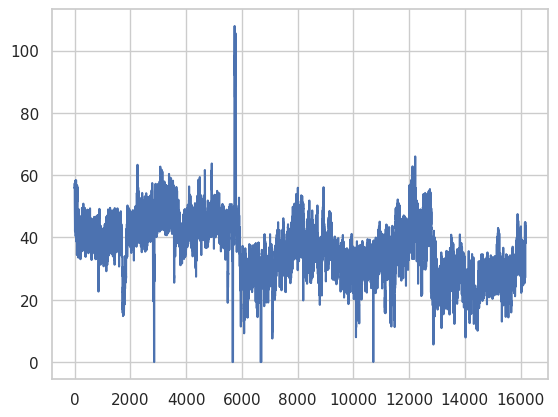

In [ ]:
window = 1241
values = data_df['HUFL'].values[window:]
sns.lineplot(values)